### It turns out that Epoch = 3, Batch Size = 8 , Learning Rate = 5e-5 performs well (without overfitting)

In [1]:
import numpy as np
import time
import json
import os
import pandas as pd
import re

from datasets import Dataset
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import DefaultDataCollator

/home/lee/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data into Pandas DF

In [2]:
## Load data

TRAIN_DATA_PATH = "./full_data/data_storage/full_train.json"
Y_TRAIN_ID_PATH = "./id_data/train.label.txt"
X_TRAIN_ID_PATH = "./id_data/train.data.txt"   # train

DEV_DATA_PATH = "./full_data/data_storage/full_dev.json"
Y_DEV_ID_PATH = "./id_data/dev.label.txt"
X_DEV_ID_PATH = "./id_data/dev.data.txt"   # dev

TEST_DATA_PATH = "./full_data/data_storage/test_full_v2.json"
X_TEST_ID_PATH = "./id_data/test.data.txt"   # test

In [3]:
## Import Twitter Processer
#!pip install tweet-preprocessor

import preprocessor as p
i = "@Telegraph How \n\n very sad. @Telegraph @Telegraph"
p.clean(i)

'How very sad.'

In [4]:
def convert_replies_id_to_sorted_text(list_of_id, data_df):
    """Convert a list of tweet ids to a list of its corresponding text in data_df
    Sort by tweets original create time"""
    if type(list_of_id) is not list:
        # if input is a single id convert type
        list_of_id = [list_of_id]
    # Select dataframe based on a list of ids
    selected_df = data_df[data_df['id'].astype(str).isin(list_of_id)]
    # Sort by their created time
    sorted_df = selected_df.sort_values(by = ["created_at"])
    # Select text fields only
    text_list = sorted_df["text"].to_list()
    return text_list


def remove_URL(original):
    """Remove url link in the text"""
    result = re.sub(r"http\S+", "", original)
    result = re.sub(r"www.\S+", "", result)
    result = re.sub(r"wasap.my+", "", result)
    return result

def join_data_id_label_v2(LABEL_PATH, ID_PATH, DATA_PATH):
    # Process Labels
    if LABEL_PATH:
        # 1: Rumour
        # 0: NonRumour
        with open(LABEL_PATH, "r") as f:
            y_label = f.read().strip().split("\n") # remove next line
        y_label = pd.DataFrame(y_label, columns = ["label"])
        y_label[y_label["label"]=="rumour"] = 1
        y_label[y_label["label"]=="nonrumour"] = 0

    ## Get Dataframe Id, with first id as source Id, and values as replies, not using dict since we have duplicated keys
    total_id_list = []
    with open(ID_PATH, "r") as f:
        for line in f:
            line = line.strip().split(',') # remove next line
            source_id = line[0]
            if len(line) > 1:
                # if we have replies id
                replies_id = line[1:]
            else:
                replies_id = []
            row = [source_id, replies_id]
            total_id_list.append(row)
    len(total_id_list)
    
    ## Create a dataframe containing a list of replies
    source_df = pd.DataFrame(total_id_list, columns = ['source_id', 'replies_id'])
    data_df = pd.read_json(DATA_PATH)
    source_df["reply_text_list"] = source_df["replies_id"].apply(convert_replies_id_to_sorted_text, data_df = data_df)
    source_df["source_text"] = source_df["source_id"].apply(convert_replies_id_to_sorted_text, data_df = data_df)

    if LABEL_PATH:
      source_df["label"] = y_label
    return source_df

def bert_preprocess(IDS, DATA, LABELS=False):
    """Function to combine all the preprocessing steps"""
    data = join_data_id_label_v2(LABELS, IDS, DATA)
    ## 1. Only keep english tweets as most of them are in english
    # Use only text data and remove URLs
    #data["source"] = data["source_text"].apply(" ".join).apply(p.clean) 
    #data["replies"] = data["reply_text_list"].apply(" ".join).apply(p.clean)
    data["source"] = data["source_text"].apply(" ".join).apply(remove_URL) 
    data["replies"] = data["reply_text_list"].apply(" ".join).apply(remove_URL)
    
    
    if LABELS:
      data = data[['source','replies','label']]
    else:
      data = data[['source','replies']]
    
    return data

In [5]:
## Keep only source text as a column AND concatenated reply strings as another column
data_train = bert_preprocess(X_TRAIN_ID_PATH, TRAIN_DATA_PATH, LABELS=Y_TRAIN_ID_PATH)
data_train

,source,replies,label
0,5. Can regularly rinsing your nose with saline...,4. Can eating garlic help prevent infection wi...,0
1,French police chief killed himself after #Char...,@Telegraph How very sad. @Telegraph @Telegraph...,1
2,Coronavirus disease (COVID-19) advice for the ...,Infection control for suspected or confirmed C...,0
3,Ottawa police confirm that there were multiple...,@WSJ Killers go berserk when cornered. Hencef...,0
4,if the primary focus of a government isn't to ...,,0
...,...,...,...
1890,Desperate Ted Cruz Claims Planned Parenthood S...,@Bipartisanism \nDesperate! @Bipartisanism Cr...,1
1891,"""Thoughts and prayers are not enough."" Pres. O...",.@ABC has anyone else noticed mass shootings s...,1
1892,Police have surrounded this building where the...,@NBCNews bury them in their hole @NBCNews @Wik...,0
1893,,@Kirstenjoyweiss @MattFabrication @prestone85 ...,0


In [6]:
## Keep only source text as a column AND concatenated reply strings as another column
data_dev = bert_preprocess(X_DEV_ID_PATH, DEV_DATA_PATH, LABELS=Y_DEV_ID_PATH)
data_dev

,source,replies,label
0,COVID-19 Fact:\nAre hand dryers effective in k...,"@WeatherBug They are, in fact, germ-breeding f...",0
1,@atruchecks when can we expect the result of m...,@ewart_lynne @atruchecks Hi have you had any l...,0
2,How does COVID-19 spread? \n\nPeople can catch...,I've read a lot about Corona virus lately and ...,0
3,"every news outlet using headlines like,\n\n""ar...","@TuckyAalto Apparently, when a headline is a q...",0
4,Researcher @naskrecki on his encounter with a ...,@Harvard @naskrecki eu tenho uma dessas em cas...,0
...,...,...,...
627,"or cure for COVID-19. However, there are sever...",WHAT ARE THE TREATMENT OPTIONS FOR COVID-19 (I...,0
628,"After speculation that he’s been arrested, Ban...",@artnet @xklamation there was a story saying s...,1
629,*Your questions answered*❓\n\n*Reply with the ...,s?\n\n14. Can I catch COVID-19 from infected s...,0
630,"►#Anonymous Operation #KKK ►Ku Klux Klan, We n...",@AnonymousVideo @grannyrosie3 @AnonymousVideo...,1


## Convert Pandas Dataframe to Transformer DataSet

In [7]:
dataset_train = Dataset.from_pandas(data_train)
dataset_train

Dataset({
    features: ['source', 'replies', 'label'],
    num_rows: 1895
})

In [8]:
dataset_dev = Dataset.from_pandas(data_dev)
dataset_dev

Dataset({
    features: ['source', 'replies', 'label'],
    num_rows: 632
})

In [9]:
total_train = pd.concat([data_dev,data_train], axis=0)
dataset_total_train = Dataset.from_pandas(total_train)

## Transformer Dataset to TensorFlow TF Dataset

Makin use of Transformer Dataset

In [10]:
BERT_MODEL = "bert-base-cased"
NUM_EPOCHS = 6
BATCH_SIZE = 8
DROPOUT = 0.2

In [11]:
## Set up Tokenizer


tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

## Tokenize with two sentences separated by [SEP]m, use source and reply as two sentences
def tokenize_function(dataset):
    return tokenizer(dataset["source"], dataset["replies"], padding="max_length", truncation=True)

# Set up Train data
tokenized_train_datasets = dataset_train.map(tokenize_function, batched=True)
# Set up Dev Data
tokenized_dev_datasets = dataset_dev.map(tokenize_function, batched=True)


# Set up Total Data
tokenized_total_datasets = dataset_total_train.map(tokenize_function, batched=True)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.08ba/s]


In [12]:
## Use data_collator to batch the dataset
data_collator = DefaultDataCollator(return_tensors="tf")

In [13]:
tf_train_dataset = tokenized_train_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = tokenized_dev_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)



tf_totaltrain_dataset = tokenized_total_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

2022-05-08 00:26:19.055666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 00:26:19.067350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 00:26:19.067650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 00:26:19.068582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Tensor Flow Bert Model

Use Training Set to train and test against dev set

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:


## Define Model
# model = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2,
#         attention_probs_dropout_prob=DROPOUT,
#         hidden_dropout_prob=DROPOUT)

model = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)


## Set up optimisation method, minimise which loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)


2022-05-08 00:26:22.706091: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Fit model
#model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=NUM_EPOCHS)


Text(0.5, 1.0, 'Train VS DEV accuracy, Learning_Rate = 5e-5')

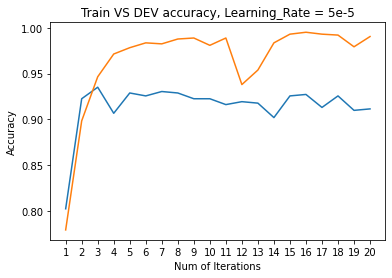

In [17]:
import matplotlib.pyplot as plt

train_acc = [0.7791, 0.8983, 0.9465, 0.9714, 0.9783, 0.9836, 0.9825, 0.9878, 0.9889, 0.9809, 0.9889, 0.9380, 0.9539, 0.9836, 0.9931, 0.9952, 0.9931, 0.9921, 0.9793, 0.9905]
dev_acc = [0.8022, 0.9225, 0.9351, 0.9066, 0.9288, 0.9256, 0.9304, 0.9288, 0.9225, 0.9225, 0.9161, 0.9193, 0.9177, 0.9019, 0.9256, 0.9272, 0.9130, 0.9256, 0.9098, 0.9114]

x = range(1, len(train_acc)+1)
plt.rcParams['figure.dpi'] = 200

plt.plot(x, dev_acc)
plt.plot(x, train_acc)
plt.xticks(range(1, len(train_acc)+1))

plt.xlabel("Num of Iterations")
plt.ylabel("Accuracy")

plt.title("Train VS DEV accuracy, Learning_Rate = 5e-5")

## Train using Train + Dev Set

In [18]:
# Fit model
model.fit(tf_totaltrain_dataset, validation_data=tf_validation_dataset, epochs=NUM_EPOCHS)


Epoch 1/6
315/315 [==============================] - 87s 258ms/step - loss: 0.4098 - sparse_categorical_accuracy: 0.8012 - val_loss: 0.2621 - val_sparse_categorical_accuracy: 0.9098
Epoch 2/6
315/315 [==============================] - 81s 256ms/step - loss: 0.4366 - sparse_categorical_accuracy: 0.8198 - val_loss: 0.5159 - val_sparse_categorical_accuracy: 0.7959
Epoch 3/6
315/315 [==============================] - 81s 257ms/step - loss: 0.4826 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.5300 - val_sparse_categorical_accuracy: 0.7801
Epoch 4/6
315/315 [==============================] - 81s 257ms/step - loss: 0.5348 - sparse_categorical_accuracy: 0.7798 - val_loss: 0.5286 - val_sparse_categorical_accuracy: 0.7801
Epoch 5/6
315/315 [==============================] - 83s 265ms/step - loss: 0.5357 - sparse_categorical_accuracy: 0.7782 - val_loss: 0.5270 - val_sparse_categorical_accuracy: 0.7801
Epoch 6/6
315/315 [==============================] - 80s 256ms/step - loss: 0.5352 - spars

## Test on Test Set

In [19]:
test_df = bert_preprocess(X_TEST_ID_PATH, TEST_DATA_PATH)
test_dataset = Dataset.from_pandas(test_df)  # Convert to Transformer Dataset

In [20]:
# Convert to Keras input for Bert model
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
tf_test_dataset = tokenized_test_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.46ba/s]


In [21]:
y_pred = model.predict(tf_test_dataset)

In [22]:
# generate the csv for prediction
def generate_csv(pred, csv_name):
    ids = pd.Index(range(len(pred)), name='Id')
    predictions = pd.DataFrame(pred, index=ids)
    predictions.columns = ['Predicted']
    predictions.to_csv(csv_name)

def model_output_to_label(model_output):
    """Conver the output class of a tensorflow model to label"""
    logit_df = pd.DataFrame(model_output.to_tuple()[0], columns = ["0","1"])
    ## Choose highest logit as the predicted class
    logit_df["label"] = logit_df.apply(lambda x: 0 if x["0"] > x["1"] else 1, axis=1)
    return logit_df["label"]

In [23]:
labels = model_output_to_label(y_pred)
generate_csv(labels, "./output/vanillabertmodel.csv")